In [1]:
%matplotlib inline
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import networkx as nx

from model.training.rollout_data import RolloutDataset as Buffer
from task.gridworld import CnnWrapper, ThreadTheNeedleEnv
from utils.config_utils import parse_task_config, parse_model_config, load_config
from utils.pytorch_utils import DEVICE
from model.agents.value_iteration import ValueIterationAgent
import seaborn as sns
from utils.pytorch_utils import (
    convert_float_to_8bit
)

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.13 (main, Sep 11 2023, 08:16:02) [Clang 14.0.6 ]
torch 2.2.1
device = mps


In [2]:
import pickle
with open('simulations/ppo_batched_data.pkl', 'rb') as f:
    batch_data = pickle.load(f)

/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_timesteps', ylabel='cumulative_reward'>

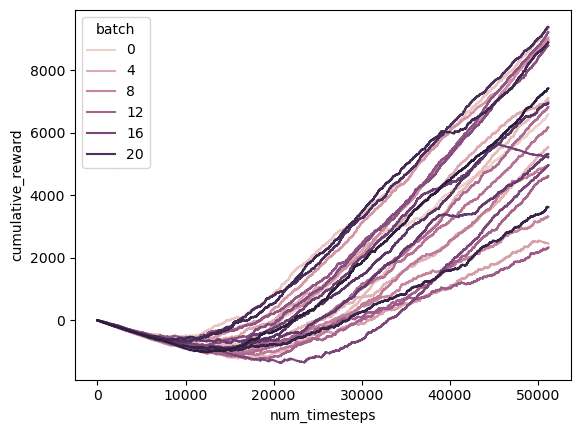

In [7]:
reward_df = []
for ii, data in enumerate(batch_data):
    _rew = pd.DataFrame(data['rewards'])
    _rew['batch'] = ii
    _rew['cumulative_reward'] = _rew['rewards'].cumsum()
    reward_df.append(_rew)
reward_df = pd.concat(reward_df)
sns.lineplot(data=reward_df, x='num_timesteps', y='cumulative_reward', hue='batch')


/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nicholasfranklin/miniconda3/envs/state_inference/lib/python3.10/site-

Text(0.5, 0.98, 'PPO Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

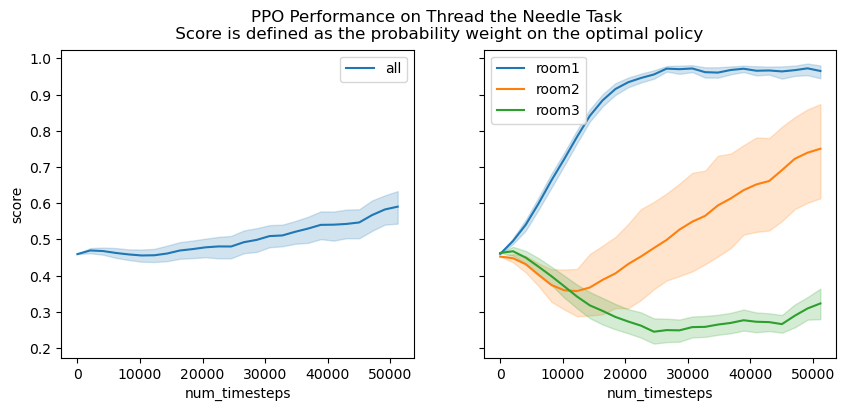

In [34]:
scores = []
for ii, batch in enumerate(batch_data):
    scores_ = pd.DataFrame(batch['evaluations']).drop(columns=['policy_pmf'])
    scores_['batch'] = ii
    scores.append(scores_)
scores = pd.concat(scores)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.lineplot(data=scores, x='num_timesteps', y='score', label='all', ax=axes[0])

sns.lineplot(data=scores, x='num_timesteps', y='score_room1', label='room1', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room2', label='room2', ax=axes[1])
sns.lineplot(data=scores, x='num_timesteps', y='score_room3', label='room3', ax=axes[1])
plt.suptitle('PPO Performance on Thread the Needle Task\n Score is defined as the probability weight on the optimal policy')

In [25]:
scores

,score,score_room1,score_room2,score_room3,num_timesteps,batch
0,0.459160,0.459686,0.452361,0.462296,0,0
1,0.489146,0.521130,0.445259,0.495097,2048,0
2,0.479198,0.587579,0.400238,0.464486,4096,0
3,0.486626,0.655382,0.370965,0.460079,6144,0
4,0.503420,0.730319,0.341020,0.471170,8192,0
...,...,...,...,...,...,...
21,0.567637,0.896290,0.964888,0.204686,43008,23
22,0.589785,0.928473,0.953241,0.238713,45056,23
23,0.587559,0.934856,0.901048,0.257167,47104,23
24,0.619421,0.935267,0.918344,0.312037,49152,23
